In [27]:
import pandas as pd
path = 'MasterDataset_Cookpad_2018thru2022_AllCountries.xlsx'
# 1) read with a 2‑row header
df = pd.read_excel(path, header=[0,1])

# 2) look at what pandas called those first three columns
print(df.columns[:3].tolist())
# → you’ll see three tuples: Unnamed:0, Unnamed:1, Unnamed:2

# 3) rename them so that the *third* one is 'Subset'
cols = list(df.columns)
cols[0] = ('Country','')   # first column is country
cols[1] = ('Demo','')      # second column whatever it is
cols[2] = ('Subset','')    # third column is your category breaks
df.columns = pd.MultiIndex.from_tuples(cols)

# 4) forward‑fill those row‑merged cells
df[['Country','Demo','Subset']] = df[['Country','Demo','Subset']].ffill()

# 5) flatten the remaining MultiIndex into "Prompt + Year"
df.columns = [
    lvl0 if lvl1 == '' else f"{lvl1} {lvl0}"
    for lvl0, lvl1 in df.columns
]

# 6) melt into long form
id_vars    = ['Country','Subset']      # now pulling the correct Subset
value_vars = [c for c in df.columns if c not in id_vars+['Demo']]

tidy = df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='Prompt_Year',
    value_name='Value'
)

# 7) split Prompt_Year → Prompt, Year
split = tidy['Prompt_Year'].str.rsplit(pat=' ', n=1, expand=True)
split.columns = ['Prompt','Year']

tidy = tidy.drop(columns='Prompt_Year').join(split)
tidy['Year'] = tidy['Year'].astype(int)

# 8) select and reorder
tidy = tidy[['Country','Year','Prompt','Subset','Value']]


[('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), ('Unnamed: 1_level_0', 'Unnamed: 1_level_1'), ('Unnamed: 2_level_0', 'Unnamed: 2_level_1')]


In [28]:
print(tidy.head())

         Country  Year                                             Prompt  \
0  United States  2018  Number of Days Cooked Lunch at Home in Past Se...   
1  United States  2018  Number of Days Cooked Lunch at Home in Past Se...   
2  United States  2018  Number of Days Cooked Lunch at Home in Past Se...   
3  United States  2018  Number of Days Cooked Lunch at Home in Past Se...   
4  United States  2018  Number of Days Cooked Lunch at Home in Past Se...   

                                              Subset     Value  
0                      Country total: National total  2.700000  
1  Total number of individuals living in househol...  2.912565  
2  Total number of individuals living in househol...  2.510920  
3  Total number of individuals living in househol...  2.640778  
4  education Level: Completed elementary educatio...  2.252156  


In [29]:
# focus on the national aggregates
national = tidy[tidy.Subset == 'Country total: National total']

# get mean, median, std, and count by Prompt & Year
stats = (
    national
    .groupby(['Prompt','Year'])['Value']
    .agg(['mean','median','std','count'])
    .reset_index()
)

# apply to any DataFrame `stats`
styled = (
    stats.style
         .format({"mean":"{:.2f}", "median":"{:.2f}", "std":"{:.2f}"})
         .set_caption("National Cooking Trends Summary")
         .background_gradient(subset=["mean","median"], cmap="Blues")
)
styled


,Prompt,Year,mean,median,std,count
0,Family Member [Other Than Spouse/Partner] Cooked Dinner at Home in Past Seven Days,2018,0.50,0.49,0.15,143
1,Family Member [Other Than Spouse/Partner] Cooked Dinner at Home in Past Seven Days,2019,0.51,0.53,0.15,143
2,Family Member [Other Than Spouse/Partner] Cooked Dinner at Home in Past Seven Days,2020,0.49,0.51,0.15,116
3,Family Member [Other Than Spouse/Partner] Cooked Dinner at Home in Past Seven Days,2021,0.50,0.52,0.14,122
4,Family Member [Other Than Spouse/Partner] Cooked Dinner at Home in Past Seven Days,2022,0.51,0.54,0.15,143
5,Family Member [Other Than Spouse/Partner] Cooked Lunch at Home in Past Seven Days,2018,0.48,0.49,0.16,143
6,Family Member [Other Than Spouse/Partner] Cooked Lunch at Home in Past Seven Days,2019,0.50,0.54,0.15,143
7,Family Member [Other Than Spouse/Partner] Cooked Lunch at Home in Past Seven Days,2020,0.48,0.51,0.15,116
8,Family Member [Other Than Spouse/Partner] Cooked Lunch at Home in Past Seven Days,2021,0.49,0.52,0.15,122
9,Family Member [Other Than Spouse/Partner] Cooked Lunch at Home in Past Seven Days,2022,0.51,0.55,0.16,143


In [30]:
# styled is your Styler from before
html = styled.to_html()

with open("national_cooking_trends_summary.html","w") as f:
    f.write(html)

print("→ Written: national_cooking_trends_summary.html")


→ Written: national_cooking_trends_summary.html


In [31]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# ————————————————
# ASSUMPTION: `tidy` is already defined with columns
# ['Country','Year','Prompt','Subset','Value'].

prompt = 'Number of Days Ate Dinner Cooked at Home in Past Seven Days'
countries = sorted(tidy['Country'].unique())

country_selector = widgets.SelectMultiple(
    options=countries,
    value=[countries[0]],
    description='Countries',
    rows=10,
    layout=widgets.Layout(width='60%')
)

# Create an Output area so Voila/ipywidgets can render into it
out = widgets.Output()

def update_plot(selected_countries):
    with out:
        clear_output(wait=True)
        if not selected_countries:
            print("Please select at least one country.")
            return

        df_plot = tidy[
            (tidy.Subset == 'Country total: National total') &
            (tidy.Prompt == prompt) &
            (tidy.Country.isin(selected_countries))
        ]

        fig = px.line(
            df_plot,
            x='Year',
            y='Value',
            color='Country',
            markers=True,
            title=f"{prompt} by Country",
            labels={'Value': 'Average # Days', 'Year': 'Year'}
        )
        fig.update_layout(legend_title_text='Country')

        # 1) Show inline in notebook/Voila
        fig.show()

        # 2) **Write out** a standalone HTML file
        fig.write_html(
            "cooking_by_country.html",
            full_html=True,
            include_plotlyjs="cdn"
        )
        print("→ Written interactive HTML: cooking_by_country.html")

# Wire up the widget
country_selector.observe(lambda ev: update_plot(ev['new']), names='value')

# Display selector + plot area
display(country_selector, out)

# Draw the first one & export
update_plot(country_selector.value)


SelectMultiple(description='Countries', index=(0,), layout=Layout(width='60%'), options=('Afghanistan', 'Alban…

Output()

In [32]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# ————————————————
# ASSUMPTION: `tidy` is already defined with columns
# ['Country','Year','Prompt','Subset','Value']

# Prepare filtered national totals DataFrame
df_nat = tidy  # you already filter inside update

# Unique selectors
prompts = sorted(tidy['Prompt'].unique())
subsets = sorted(tidy['Subset'].unique())
years   = sorted(tidy['Year'].unique())

# Widgets
prompt_selector = widgets.Combobox(
    placeholder='Type or choose a prompt',
    options=prompts,
    description='Prompt:',
    ensure_option=True,
    layout=widgets.Layout(width='70%')
)
subset_selector = widgets.Combobox(
    placeholder='Type or choose a subset',
    options=subsets,
    description='Subset:',
    ensure_option=True,
    layout=widgets.Layout(width='70%')
)
year_slider = widgets.IntSlider(
    value=years[-1],
    min=years[0],
    max=years[-1],
    step=1,
    description='Year:',
    continuous_update=False,
    layout=widgets.Layout(width='70%')
)

def update_choropleth(*args):
    clear_output(wait=True)
    display(prompt_selector, subset_selector, year_slider)
    
    prompt = prompt_selector.value
    subset = subset_selector.value
    year   = year_slider.value
    
    # Validate selections
    if prompt not in prompts:
        print("Please select a valid prompt.")
        return
    if subset not in subsets:
        print("Please select a valid subset.")
        return
    
    # Filter and plot
    df_sub = tidy[
        (tidy.Prompt == prompt) &
        (tidy.Subset == subset) &
        (tidy.Year   == year)
    ]
    fig = px.choropleth(
        df_sub,
        locations='Country',
        locationmode='country names',
        color='Value',
        title=f"{prompt}\n{subset} ({year})",
        color_continuous_scale='Viridis',
        labels={'Value': 'Average Response'}
    )
    fig.show()
    
    # --- Export a standalone HTML for sharing ---
    fig.write_html(
        "cooking_choropleth.html",
        full_html=True,
        include_plotlyjs="cdn"
    )
    print("→ Written interactive HTML: cooking_choropleth.html")

# Wire events
prompt_selector.observe(update_choropleth, names='value')
subset_selector.observe(update_choropleth, names='value')
year_slider.observe(update_choropleth, names='value')

# Initial display
display(prompt_selector, subset_selector, year_slider)
update_choropleth()


Combobox(value='', description='Prompt:', ensure_option=True, layout=Layout(width='70%'), options=('Family Mem…

Combobox(value='', description='Subset:', ensure_option=True, layout=Layout(width='70%'), options=('Age cohort…

IntSlider(value=2022, continuous_update=False, description='Year:', layout=Layout(width='70%'), max=2022, min=…

Please select a valid prompt.


In [33]:
import numpy as np
import pandas as pd
from IPython.display import display

# 1) Check that you actually have quintile rows
print("All unique subsets:\n", tidy.Subset.unique(), "\n")
df_q = tidy[tidy.Subset.str.startswith("Per Capita Income Quintiles")]
print(f"Rows matching quintiles: {len(df_q)} (should be 5 × #country‐years)\n")
display(df_q.head(10))

# 2) Define the Gini function
def gini_from_quintiles(group):
    y = group.sort_values('Subset')['Value'].values
    K = len(y)
    w = np.repeat(1/K, K)
    μ = np.sum(w * y)
    diffs = np.abs(y[:, None] - y[None, :])
    G = np.sum(w[:, None] * w[None, :] * diffs) / (2 * μ)
    return G

# 3) Compute Gini per Country‐Year‐Prompt
gini_df = (
    df_q
    .groupby(['Country','Year','Prompt'])
    .apply(gini_from_quintiles)
    .reset_index(name='Gini')
)

# 4) Display the result
print("Computed Gini coefficients:")
display(gini_df.head(10))

# 5) (Optional) Quick summary stats
print("\nGini summary:")
print(gini_df.Gini.describe())


All unique subsets:
 ['Country total: National total'
 'Total number of individuals living in household: One to two'
 'Total number of individuals living in household: Three to five'
 'Total number of individuals living in household: More than five'
 'education Level: Completed elementary education or less (up to 8 years of basic education)'
 'education Level: Secondary - 3 year TertiarySecondary education and some education beyond secondary education (9-15 years of education'
 'education Level: Completed four years of education beyond high school and/or received a 4-year college degree.'
 'Payroll to Population Index (P2P): Not full-time for an employer'
 'Payroll to Population Index (P2P): Full-time for an employer'
 'Gender: Male' 'Gender: Female' 'Urban/Rural: Rural' 'Urban/Rural: Urban'
 'Subjective Income: Living comfortably' 'Subjective Income: Getting by'
 'Subjective Income: Finding it difficult or very difficult'
 'Per Capita Income Quintiles: Poorest 20%'
 'Per Capita Income

,Country,Year,Prompt,Subset,Value
16,United States,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Poorest 20%,3.002083
17,United States,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Second 20%,3.200247
18,United States,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Middle 20%,2.421647
19,United States,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Fourth 20%,2.585630
20,United States,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Richest 20%,2.438399
40,Egypt,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Poorest 20%,3.073716
41,Egypt,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Second 20%,2.837326
42,Egypt,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Middle 20%,2.432812
43,Egypt,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Fourth 20%,2.616979
44,Egypt,2018,Number of Days Cooked Lunch at Home in Past Se...,Per Capita Income Quintiles: Richest 20%,2.726574


Computed Gini coefficients:


C:\Users\aadit\AppData\Local\Temp\ipykernel_22728\2557758562.py:25: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Country,Year,Prompt,Gini
0,Afghanistan,2018,Family Member [Other Than Spouse/Partner] Cook...,0.072686
1,Afghanistan,2018,Family Member [Other Than Spouse/Partner] Cook...,0.051355
2,Afghanistan,2018,Number of Days Ate Dinner Cooked at Home in Pa...,0.015727
3,Afghanistan,2018,Number of Days Ate Lunch Cooked at Home in Pas...,0.026760
4,Afghanistan,2018,Number of Days Cooked Dinner at Home in Past S...,0.053107
5,Afghanistan,2018,Number of Days Cooked Lunch at Home in Past Se...,0.055713
6,Afghanistan,2018,Other Person Who is Not a Family Member Cooked...,0.305979
7,Afghanistan,2018,Other Person Who is Not a Family Member Cooked...,0.238009
8,Afghanistan,2018,Spouse/Partner Cooked Dinner at Home in Past S...,0.096613
9,Afghanistan,2018,Spouse/Partner Cooked Lunch at Home in Past Se...,0.096639



Gini summary:
count    6570.000000
mean        0.076174
std         0.066605
min         0.002770
25%         0.032846
50%         0.053359
75%         0.093955
max         0.487853
Name: Gini, dtype: float64


In [34]:
import plotly.io as pio

pio.renderers.default = 'notebook_connected'


In [35]:
import plotly.express as px

fig = px.choropleth(
    gini_df,
    locations='Country',
    locationmode='country names',
    color='Gini',
    animation_frame='Year',
    color_continuous_scale='Reds',
    labels={'Gini':'Gini of Cooking‑Days'},
    title="Gini Coefficient of Cooking‑at‑Home by Country over Time"
)
fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    geo=dict(showframe=False, showcoastlines=False)
)
fig.show()

In [36]:
tidy.head

<bound method NDFrame.head of                 Country  Year  \
0         United States  2018   
1         United States  2018   
2         United States  2018   
3         United States  2018   
4         United States  2018   
...                 ...   ...   
179945  Northern Cyprus  2022   
179946  Northern Cyprus  2022   
179947  Northern Cyprus  2022   
179948  Northern Cyprus  2022   
179949  Northern Cyprus  2022   

                                                   Prompt  \
0       Number of Days Cooked Lunch at Home in Past Se...   
1       Number of Days Cooked Lunch at Home in Past Se...   
2       Number of Days Cooked Lunch at Home in Past Se...   
3       Number of Days Cooked Lunch at Home in Past Se...   
4       Number of Days Cooked Lunch at Home in Past Se...   
...                                                   ...   
179945  Other Person Who is Not a Family Member Cooked...   
179946  Other Person Who is Not a Family Member Cooked...   
179947  Other Person Who

In [37]:
import statsmodels.api as sm

# 1) load the obesity data
ob = pd.read_csv('childhood_obesity.csv')

# rename/mutate to standard keys
ob = (
    ob
    .rename(columns={
        'GEO_NAME_SHORT': 'Country',       # if your CSV uses a different name, adjust here
        'DIM_TIME': 'Year',
        'RATE_PER_100_N': 'Obesity_Prevalence'
    })
    [['Country','Year','Obesity_Prevalence']]
)

# 2) pull out the relevant cooking-at-home measure from tidy
home = (
    tidy
    .loc[
        (tidy['Prompt'] == 'Number of Days Ate Dinner Cooked at Home in Past Seven Days')
      & (tidy['Subset'] == 'Per Capita Income Quintiles: Poorest 20%'),
        ['Country','Year','Value']
    ]
    .rename(columns={'Value':'Home_Cooking_Lunch_Days'})
)


In [38]:

# 3) merge and drop any missing
df = (
    pd.merge(ob, home, on=['Country','Year'], how='inner')
    .dropna(subset=['Obesity_Prevalence','Home_Cooking_Lunch_Days'])
)


In [39]:
# 1. Inspect your existing DataFrame “df” for the correct country/year column names
print("Existing df columns:", df.columns.tolist())

# 2. Load & reshape the stunting data
stunting_raw = pd.read_csv('childhood_stunting.csv', skiprows=4)
year_cols = [str(y) for y in range(2018, 2023)]
stunting_long = (
    stunting_raw
    .melt(
        id_vars=['Country Name', 'Country Code'],
        value_vars=year_cols,
        var_name='Year',
        value_name='Stunting_U5_pct'
    )
    .rename(columns={'Country Name': 'Country'})
)
stunting_long['Year'] = stunting_long['Year'].astype(int)
stunting_long['Stunting_U5_pct'] = pd.to_numeric(
    stunting_long['Stunting_U5_pct'], errors='coerce'
)

# 4. Merge stunting data into df (left join preserves all original rows)
df = df.merge(
    stunting_long[['Country', 'Year', 'Stunting_U5_pct']],
    on=['Country', 'Year'],
    how='left'
)

# 5. Fill missing: interpolate within each country, then set remaining to 0
df['Stunting_U5_pct'] = (
    df
    .groupby('Country')['Stunting_U5_pct']
    .transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    .fillna(0)
)

# 6. Verify the result
print(df[['Country', 'Year', 'Stunting_U5_pct']].drop_duplicates().head(10))

Existing df columns: ['Country', 'Year', 'Obesity_Prevalence', 'Home_Cooking_Lunch_Days']
                Country  Year  Stunting_U5_pct
0                 Ghana  2021             17.4
1                Greece  2019              0.0
2                 China  2021              0.0
3  United Arab Emirates  2022              0.0
4    Dominican Republic  2019              6.7
5           El Salvador  2020             10.0
6            Tajikistan  2019              0.0
7               Germany  2018              0.0
8             Singapore  2018              0.0
9           Philippines  2018             29.9


In [40]:
# --- 1) Load and tidy GDP data ---
gdp = pd.read_csv('national_gdps_ppp.csv', skiprows=4)

# Select columns 2018–2022 and reshape
years = [str(y) for y in range(2018, 2023)]
gdp_long = (
    gdp[['Country Name'] + years]
    .melt(
        id_vars=['Country Name'],
        value_vars=years,
        var_name='Year',
        value_name='GDP_PPP'
    )
    .rename(columns={'Country Name':'Country'})
)
gdp_long['Year'] = gdp_long['Year'].astype(int)

# --- 2) Merge into your panel dataframe ---
df = pd.merge(df, gdp_long, on=['Country','Year'], how='left')


In [41]:
# Reload without skipping any rows, then clean column names
urb = pd.read_csv('share_urban_pop.csv')
urb.columns = urb.columns.str.strip()   # trim whitespace

# Inspect to confirm
print(urb.columns.tolist())

# Now pick off the three we need
urb = (
    urb
    .rename(columns={'Start Year':'Year', 'Value':'Share_Urban_Pop'})
    [['Country','Year','Share_Urban_Pop']]
)
urb['Year'] = urb['Year'].astype(int)

# Merge into df
df = df.merge(urb, on=['Country','Year'], how='left')

['Indicator', 'Country', 'ISO3', 'Region', 'Start Year', 'End Year', 'Value', 'Unit', 'Source']


In [42]:
# --- 1) Load FLFP in wide form, skip metadata rows ---
flfp_raw = pd.read_csv('female_labor_participation.csv', skiprows=4)
flfp_raw.columns = flfp_raw.columns.str.strip()  # trim any stray whitespace

# --- 2) Melt 2018–2022 into long form ---
years = [str(y) for y in range(2018, 2023)]
flfp = (
    flfp_raw[['Country Name'] + years]
    .melt(
        id_vars=['Country Name'],
        value_vars=years,
        var_name='Year',
        value_name='Female_Labor_Participation'
    )
    .rename(columns={'Country Name':'Country'})
)
flfp['Year'] = flfp['Year'].astype(int)

# --- 3) Interpolate missing values using transform (preserves index) ---
flfp = flfp.sort_values(['Country','Year'])
flfp['Female_Labor_Participation'] = (
    flfp
    .groupby('Country')['Female_Labor_Participation']
    .transform(lambda x: x.interpolate(method='linear'))
)

# --- 4) Merge into main df ---
df = pd.merge(df, flfp, on=['Country','Year'], how='left')


In [43]:

# 1. Load the World Bank classification dataset
class_df = pd.read_csv('worldbank_classification.csv')

# 2. Rename columns to align with your df
# 'Economy' contains the country names, 'Region' contains the region name
class_df.rename(columns={
    'Economy': 'Country',
    'Region': 'RegionName'
}, inplace=True)

# 3. Merge region names into your main DataFrame, preserving all df rows
df = df.merge(
    class_df[['Country', 'RegionName']],
    on='Country',
    how='left'
)

# 4. Create one-hot dummies for each region
region_dummies = pd.get_dummies(df['RegionName'], prefix='Reg', dummy_na=False)

# 5. Append dummies and drop the original RegionName column
df = pd.concat([df, region_dummies], axis=1).drop(columns=['RegionName'])

# 6. Verify that dummies were added
print("Region dummy columns:", [col for col in df.columns if col.startswith('Reg_')])


Region dummy columns: ['Reg_East Asia & Pacific', 'Reg_Europe & Central Asia', 'Reg_Latin America & Caribbean', 'Reg_Middle East & North Africa', 'Reg_North America', 'Reg_South Asia', 'Reg_Sub-Saharan Africa']


In [44]:
# 1. Load and inspect the raw UPF spending file
upf_df = pd.read_csv('upf_spending.csv')
print("Raw UPF columns:", upf_df.columns.tolist())

# 2. Rename 'Region' to 'Country' to match your df
upf_df.rename(columns={'Region': 'Country'}, inplace=True)

# 3. Melt years 2018–2022 into long format (year, country, spending)
year_cols = [str(y) for y in range(2018, 2023)]
upf_long = upf_df.melt(
    id_vars=['Country'],
    value_vars=year_cols,
    var_name='Year',
    value_name='UPF_Sales_USDpc'
)

# 4. Convert types
upf_long['Year'] = upf_long['Year'].astype(int)
upf_long['UPF_Sales_USDpc'] = pd.to_numeric(upf_long['UPF_Sales_USDpc'], errors='coerce')

# 5. Merge into your main DataFrame `df` (left join preserves all original rows)
df = df.merge(
    upf_long[['Country', 'Year', 'UPF_Sales_USDpc']],
    on=['Country', 'Year'],
    how='left'
)

# 6. Sort and interpolate within each Country group
df = df.sort_values(['Country', 'Year'])
df['UPF_Sales_USDpc'] = (
    df.groupby('Country')['UPF_Sales_USDpc']
       .transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
)

# 7. Verify the merged & interpolated data
print(df[['Country', 'Year', 'UPF_Sales_USDpc']].drop_duplicates().head(10))

Raw UPF columns: ['Region', '2017', '2018', '2019', '2020', '2021', '2022', '▼ 2023']
         Country  Year  UPF_Sales_USDpc
184  Afghanistan  2018             21.8
89   Afghanistan  2019             21.4
241  Afghanistan  2021             21.5
242  Afghanistan  2022             25.1
243      Albania  2018            276.2
534      Albania  2019            285.1
135      Albania  2020            338.6
485      Albania  2021            373.8
19       Albania  2022            474.4
584      Algeria  2018            131.2


In [50]:
import statsmodels.api as sm
import pandas as pd

# 1) List all controls exactly as they appear in df
base_controls = [
    'Home_Cooking_Lunch_Days',
    'Female_Labor_Participation',
    'Share_Urban_Pop',
    'GDP_PPP',
    'Stunting_U5_pct',
    'UPF_Sales_USDpc'
]
region_controls = [col for col in df.columns if col.startswith('Reg_')]
all_controls = base_controls + region_controls

# 2) Subset X and outcome y
X = df[all_controls].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(df['Obesity_Prevalence'], errors='coerce')

# 3) Drop any remaining NaNs
data_clean = pd.concat([y, X], axis=1).dropna()
y_clean = data_clean['Obesity_Prevalence']
X_clean = data_clean[all_controls]


print("Outcome dtype:", y_clean.dtype)
print("Exog dtypes:\n", X_clean.dtypes)

# 2) Force‐cast all to float
X_clean = X_clean.astype(float)
y_clean = y_clean.astype(float)

# 3) Now fit the model
model_ctrl = sm.OLS(y_clean, sm.add_constant(X_clean)).fit()
print(model_ctrl.summary())


# 4) Add intercept and fit
X_clean = sm.add_constant(X_clean)
model_ctrl = sm.OLS(y_clean, X_clean).fit()

# 5) View results
print(model_ctrl.summary())


Outcome dtype: float64
Exog dtypes:
 Home_Cooking_Lunch_Days           float64
Female_Labor_Participation        float64
Share_Urban_Pop                   float64
GDP_PPP                           float64
Stunting_U5_pct                   float64
UPF_Sales_USDpc                   float64
Reg_East Asia & Pacific              bool
Reg_Europe & Central Asia            bool
Reg_Latin America & Caribbean        bool
Reg_Middle East & North Africa       bool
Reg_North America                    bool
Reg_South Asia                       bool
Reg_Sub-Saharan Africa               bool
dtype: object
                            OLS Regression Results                            
Dep. Variable:     Obesity_Prevalence   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     505.1
Date:                Tue, 17 Jun 2025   Prob (F-statistic):               0.00
Time:   

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Subset to just the three predictors and drop any rows with missing values
X = df[['Home_Cooking_Lunch_Days','GDP_PPP','Share_Urban_Pop','Female_Labor_Participation']].dropna()

# 2) Add constant (VIF will include it but you can ignore its entry)
X_const = sm.add_constant(X)

# 3) Compute VIF for each column
vif = pd.DataFrame({
    'variable': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})

print(vif)

                     variable       VIF
0                       const  0.000000
1     Home_Cooking_Lunch_Days  1.039538
2                     GDP_PPP  1.006522
3             Share_Urban_Pop  1.039335
4  Female_Labor_Participation  1.000852


c:\Users\aadit\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide



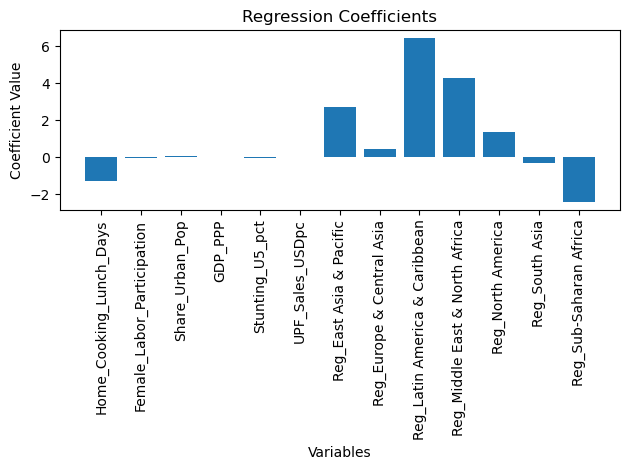

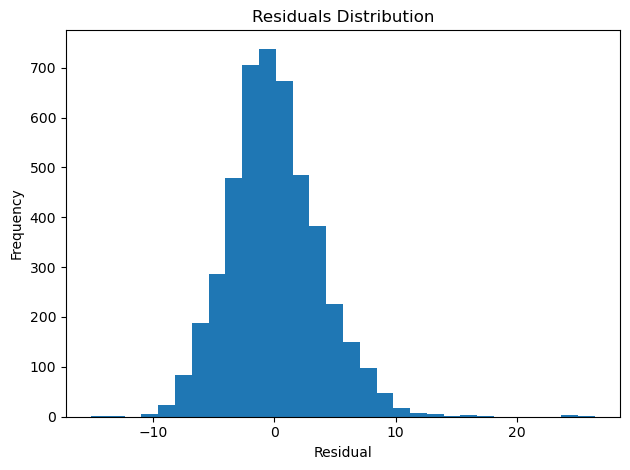

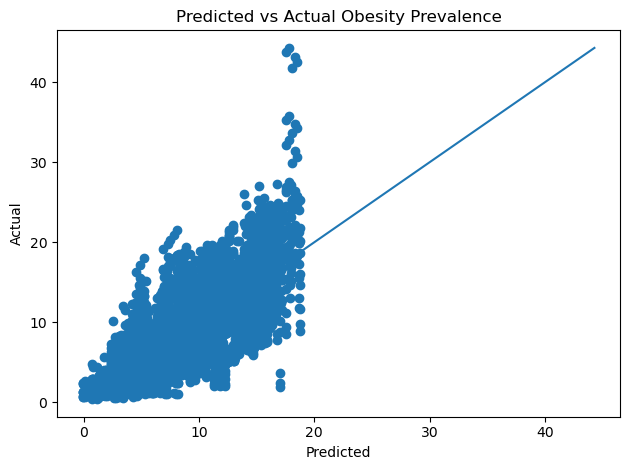

In [52]:
import matplotlib.pyplot as plt
# 1) Bar chart of regression coefficients (excluding the intercept)
coef = model_ctrl.params.drop('const')
plt.figure()
plt.bar(coef.index, coef.values)
plt.xticks(rotation=90)
plt.title('Regression Coefficients')
plt.xlabel('Variables')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

# 2) Histogram of residuals
resid = model_ctrl.resid
plt.figure()
plt.hist(resid, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3) Scatter plot: Predicted vs Actual Obesity Prevalence
fitted = model_ctrl.fittedvalues
actual = y_clean  # from your cleaned data used in the model
plt.figure()
plt.scatter(fitted, actual)
# 45-degree reference line
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()])
plt.title('Predicted vs Actual Obesity Prevalence')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


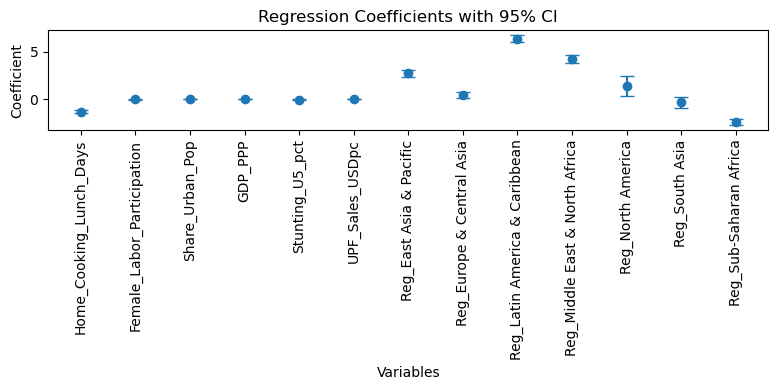

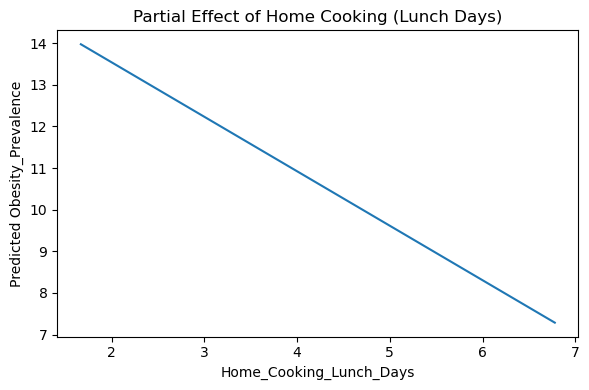

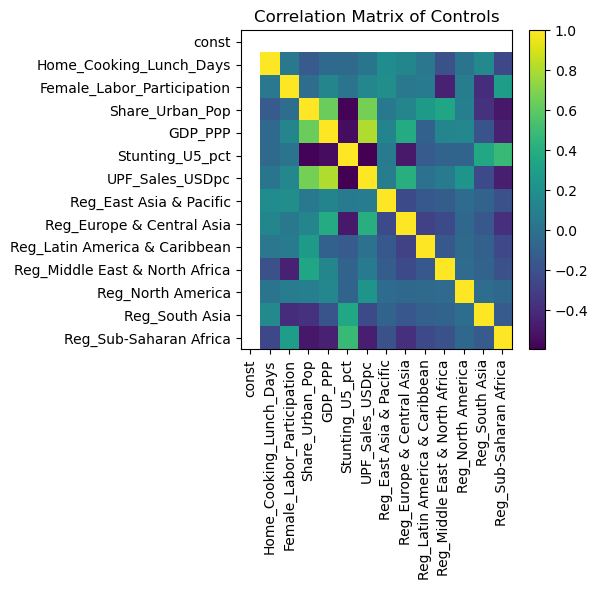

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.regressionplots import influence_plot

# --- Assumes model_ctrl and X_clean are in memory ---

# 1) Coefficient plot with 95% confidence intervals (excluding intercept)
params = model_ctrl.params.drop('const')
conf = model_ctrl.conf_int().drop('const')
low_err = params - conf[0]
high_err = conf[1] - params

plt.figure(figsize=(8, 4))
plt.errorbar(params.index, params.values, yerr=[low_err.values, high_err.values], fmt='o', capsize=5)
plt.xticks(rotation=90)
plt.title('Regression Coefficients with 95% CI')
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.tight_layout()
plt.show()

# 2) Partial effect of Home_Cooking_Lunch_Days
hc_vals = np.linspace(X_clean['Home_Cooking_Lunch_Days'].min(),
                      X_clean['Home_Cooking_Lunch_Days'].max(), 50)
exog_names = model_ctrl.model.exog_names  # includes 'const' first
# Build prediction DataFrame with correct columns
pred_df = pd.DataFrame(index=range(len(hc_vals)), columns=exog_names)
pred_df['const'] = 1.0
for name in exog_names[1:]:
    if name == 'Home_Cooking_Lunch_Days':
        pred_df[name] = hc_vals
    else:
        pred_df[name] = X_clean[name].mean()

# Generate predictions
preds = model_ctrl.predict(pred_df.astype(float))

plt.figure(figsize=(6,4))
plt.plot(hc_vals, preds, label='Predicted Obesity')
plt.title('Partial Effect of Home Cooking (Lunch Days)')
plt.xlabel('Home_Cooking_Lunch_Days')
plt.ylabel('Predicted Obesity_Prevalence')
plt.tight_layout()
plt.show()

# 4) Correlation matrix heatmap of controls
plt.figure(figsize=(6,6))
corr = X_clean.corr()
plt.imshow(corr, interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix of Controls')
plt.tight_layout()
plt.show()
